In [0]:
%ls

gdrive/  sample_data/  somefile.txt


# Daniel Maguire - X00127907 - AI CA2

## 1.1 Introduction
A brief introduction about this project. I started out using google colab to try and take advantage of using their GPU for faster training and grid searching. I then learned about their other option for runtime, TPU (Tensorflow processing unit) and was eager to play around with it as it is designed for running this kind of stuff. However, in the long run, I ended up having a lot of trouble when it came time to grid search as I lost a night of grid searching twice, due to restrictions put on kernals running over long periods of time. I thought I was checkpointing my grid searching efforts, but it turned out I misunderstood how Keras callbacks interact when used with GridSearchcv and I ended up not being able to restore my checkpointed progress after many hours of running.


  After this disaster I chose to ditch trying to checkpoint my grid searching efforts and to move the project to a local anaconda environment with minimal packages installed apart from what I needed. This allowed me to use the parameter n_jobs=-1 during my grid searching, which would account for about 90% of my running time over the course of the project. However, I ran into memory leak issues, causing my grid search to crash after hours of running. I then learned to use the pre_dispatch parameter in the grid search along with n_jobs in order to properly manage memory and cause the crashing to stop. These parameters were not possible to run on colab or azure notebooks due to the architecture of those softwares. Once I had figured out how to utilize these parameters locally, grid searching became a breeze thanks to my 6 core 12 thread CPU allowing me to run searches rather fast and make improvements in my model.
  
  
  If I learned anything from this project, it’s that if I were to do it again, I would start locally with anaconda instead of trying to make use of GPU’s and TPU’s hosted in the cloud. I’ve learned that thankfully my machine is strong enough to be able to train deep learning algorithms locally. Now on to the project.


## 1.2 Imports
Here are our imports, as is expected we are using NumPy, pandas and popular graphing library matplotlib. We are generating our dataset using sklearn’s make_blobs from their sample generator library and we are building our neural net using Keras. Some of the more uncommon imports here would be seaborn, and google.colab. 


   Seaborn is a python statistical data visualization library based on matplotlib, it provides a high level interface for drawing attractive and informative statistical graphs. I quite like some of the graphs that can be made using Seaborn so I may use this over matplotlib at times, hopefully to enable better explanation of the data and findings. 
   

   I use google.colab import drive in order to properly implement checkpointing in my grid searches, due to the nature of colab, it is isolated from your personal google drive in its runtime. So by importing drive I can save all the .hdf5 files that I want, containing my best weights and parameters for my grid searches. Running our imports cell allows me to authenticate my google account using an auth key.


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from keras.utils import np_utils 
from keras.models import Sequential 
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import pickle

# Check that gdrive is working for storing checkpoint files
# from google.colab import drive
# drive.mount('/content/gdrive')

sns.set(style="ticks")

In [ ]:
# check drive is connected
!ls '/content/gdrive/My Drive'

## 1.3 Creating the dataset

To create the dataset we will be using sklearn.datasets make blobs method, this method generates isotropic gaussian blobs designed for clustering. I am using the following assigned parameters for creation of the dataset
* n_samples = 100,000
* centers = 5
* n_features = 86
* cluster_std = 123
* seed = 23

I then split the data in a 80:20 train test split, where we shall develop and train our model on the 80% and keep the remaining 20% of the dataset for unseen testing once we have our finished model


In [14]:
# using smaller values for now, 
# features = 86
# classes = 5
# cluster std = 123

n_features = 86
n_class = 5

X, y = make_blobs(n_samples=100000, centers=n_class, cluster_std=123,
n_features=n_features, random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# assigned seed value
seed = 23 
np.random.seed(seed)

print(X_train[0]) 
print(y_train[0])

[  73.4785484   129.3255492   183.85160688  -19.71475968  330.18948836
  -11.14481777   78.82260928    6.28100229   30.4012036   120.98537637
 -120.30795281  -83.46759972   35.758575    -50.90558037 -205.22375629
   -0.4404256   -43.9723486   -19.81730829  154.41428524   36.12771353
  -91.60993767 -186.81961199  131.59916817  234.16318421   20.57312711
 -184.72912385   81.3940172  -190.69263926  -52.45781648    9.96460483
 -143.81392738   25.3523589   207.03847807  -21.744931    317.23251454
   41.78398366  -40.53076944 -126.12411338  176.87475843  135.50897704
 -173.23044279 -156.27139563  -59.29802104  186.5603993   102.9764442
   68.10198235 -282.79187993   59.00739591  -80.37150966   98.4517728
  -22.72768556 -101.52007338  200.7086301   140.74307414   67.16989486
  -89.70105549   72.08863197  109.59093357  246.5786073   -98.53199807
   87.28212584   98.3795302   222.08431838   61.34245131  -76.62150224
  -26.05082879   24.30850753   84.12953588 -131.43617578  267.36380024
   47.13

## 1.4 Data Exploration

Here we will attempt to do some exploration of the blob dataset. First, I will turn the data into a pandas data frame in order to make exploratory data analysis easier.


In [15]:
# make some pandas df's for easier EDA
feature_cols = ['x{}'.format(x) for x in range(n_features)]

# training data
df_train = pd.DataFrame(X_train,columns=feature_cols)
df_train['y'] = y_train

# test data
df_test = pd.DataFrame(X_test,columns=feature_cols)
df_test['y'] = y_test

We will look at the shape of our data, you might notice we have 87 columns, this is perfectly fine as one of our colums is Y, not part of the 86 features


In [4]:
# look at shape of your data
print('df_train shape = {}'.format(df_train.shape))
print('df_test shape = {}'.format(df_test.shape))

df_train shape = (80000, 87)
df_test shape = (20000, 87)


In [8]:
# look at train data
df_train.head()

#LAST COLUMN IS Y, this is reason for 87 feature

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x77,x78,x79,x80,x81,x82,x83,x84,x85,y
0,69.644258,-143.954911,124.548816,-139.484203,-30.717040,0.479478,-69.925000,-170.794257,4.700090,-37.450654,...,-8.190191,-130.790723,-291.170531,-159.849737,21.740255,79.064492,-276.751193,-56.137424,132.066655,2
1,-76.159887,56.475978,4.691005,25.055718,-24.109261,40.494691,-24.957179,78.826808,20.406328,-154.819065,...,-145.782270,172.963008,-34.117877,171.352331,136.684289,-87.906398,26.465475,-6.192313,-32.529201,1
2,59.364663,135.363798,8.738125,-230.546109,-64.165901,44.707145,118.020542,-16.104418,-100.232442,-13.946875,...,17.167181,133.182149,-78.436530,111.984234,-121.356381,-125.426157,156.227858,-214.318785,-100.422450,4
3,130.540487,-179.069750,-162.753651,186.454959,-83.455588,111.176278,-111.795029,-40.722315,-96.985559,-14.968255,...,-23.586438,-29.647693,-138.240733,-0.275365,-6.081906,112.670787,-6.034459,-138.083518,46.181339,4
4,-90.711789,22.392556,-34.422966,29.394924,239.281881,87.875643,278.308433,-137.790240,-149.847192,42.253248,...,-65.456597,-65.352376,-43.566457,-134.971190,-36.724267,124.046678,55.541273,-16.342797,135.123925,3


Below we can see some of the statistics of our data, including the mean and std. However, this isn’t incredibly useful as from what we can tell by looking, each feature is rather similar in values. None seem to be incredible outliers from our initial inspection

In [9]:
# get some summary stats on the training data
df_train_stats = df_train.describe().transpose()

df_train_stats.head()

,count,mean,std,min,25%,50%,75%,max
x0,8000.0,-2.013600,121.805569,-470.182558,-82.164370,-1.719846,79.591660,461.461548
x1,8000.0,2.104299,123.787413,-469.648166,-79.941279,4.327363,86.380056,465.512605
x2,8000.0,1.515670,122.742608,-430.703604,-81.396779,1.659623,84.262800,462.305307
x3,8000.0,1.231144,123.599219,-506.837444,-82.786523,1.437175,83.108836,532.349655
x4,8000.0,1.164738,122.609369,-436.695966,-83.385697,3.478205,83.010900,471.694180


In [10]:
df_train_stats.tail()

,count,mean,std,min,25%,50%,75%,max
x82,8000.0,2.528174,122.913630,-471.599643,-80.818256,0.706821,87.269979,502.984778
x83,8000.0,4.137801,122.293530,-453.801434,-78.851073,4.613930,86.983423,430.472479
x84,8000.0,-1.096063,123.521959,-537.471324,-84.672088,-1.568588,82.618555,441.352385
x85,8000.0,6.719380,122.521251,-439.102647,-75.003448,4.503986,89.309202,455.083726
y,8000.0,2.004750,1.412702,0.000000,1.000000,2.000000,3.000000,4.000000


To try get a bit of a better visualisation of the data, below I take five feature columns and the mean of their five clusters. Then I fit them to a barplot for visualising. We can see that features x81 and x20 and x43 have seemingly randomly distributed values for means across all five of the clusters, where features x81 and x23 have mostly positive means. This doesn’t tell us much of anything, however. Just that the data we’re working with has indeed got some variance when it comes to features mean values.

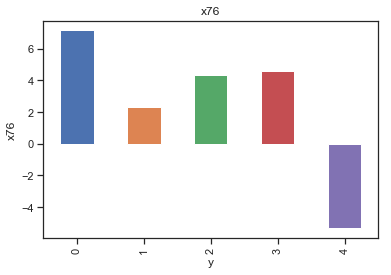

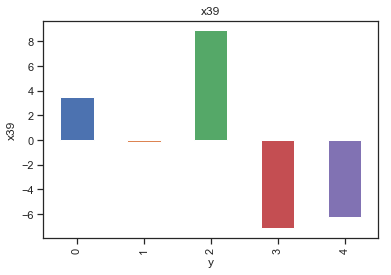

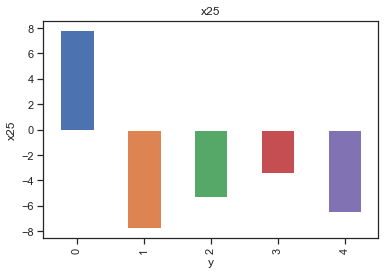

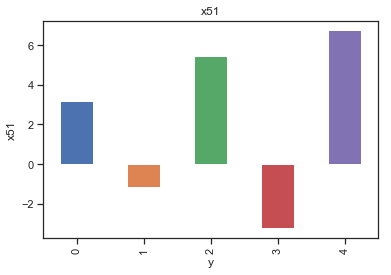

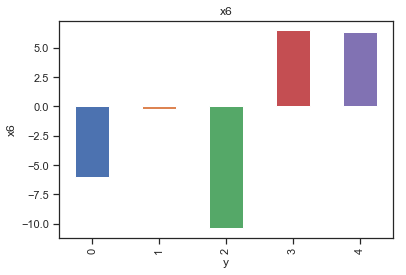

In [5]:
for col in np.random.choice(feature_cols,5):
    bar_plot = df_train.groupby('y').mean()[col].plot(kind='bar')
    bar_plot.set_title(col)
    bar_plot.set_ylabel(col)
    plt.show()

Here we try to go into a bit more detail, investigating various metrics of one of the clusters to see can we identify anything that would be telling of any traits about our data. The first thing I see is that we have a bell curve standard deviation which is to be expected. We have a bimodal graph for our mean, this strikes me as an interesting finding and we will keep it in mind in the future.


Plots for label=0


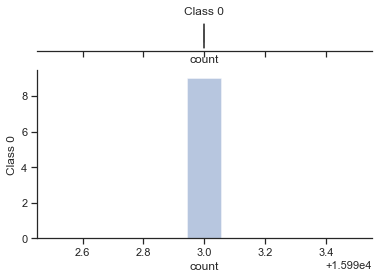

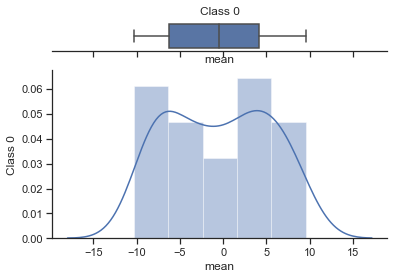

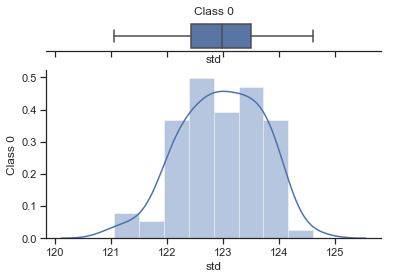

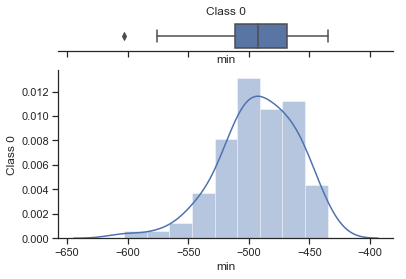

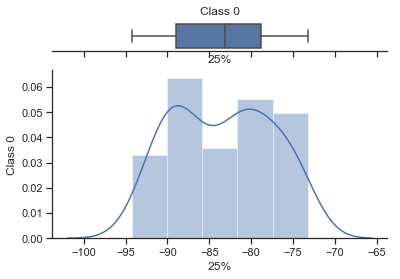

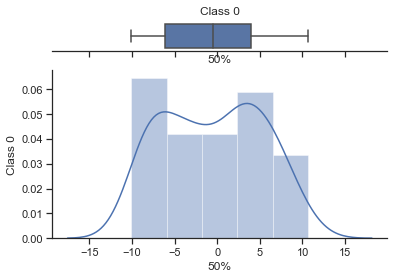

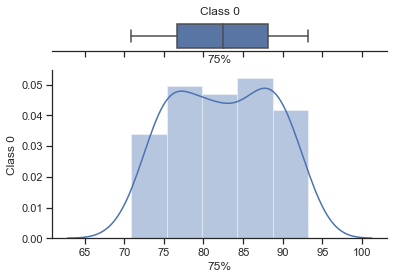

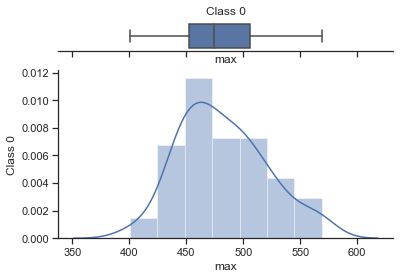

In [12]:
# get a list of our labels
labels = np.sort(df_train['y'].unique())

# get summary stats for each class and plot them
for label in np.random.choice(labels,1):
    print('Plots for label={}'.format(label))
    df_train_stats = df_train.loc[df_train['y']==label].describe().transpose()
    for col in df_train_stats.columns:
        x = df_train_stats.loc[df_train_stats.index!='y'][col]
        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
        sns.boxplot(x, ax=ax_box)
        sns.distplot(x, ax=ax_hist)
        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
        ax_box.set_title('Class {}'.format(label))
        ax_hist.set_ylabel('Class {}'.format(label))
        plt.show()

I thought we should do some principal component analysis to perhaps get a better understanding of the data however we can see there are no gains to be made from dimensionality reduction. All of the X features seem to be linearly independent, meaning PCA is no use in this case.

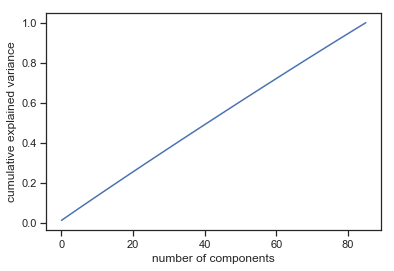

In [7]:
# lets try some pca to explore potential for dimensionality reduction
#Explained variance
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## 2.1 Data Preprocessing
Here we will begin to create our model, first we must pre-process our X data by scaling it using standard scaler. We then change our Y data from integer data to categorical data.

In [16]:
# preprocess data by scaling it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# enocde values to categorical from Int. 
y_train_encoded = np_utils.to_categorical(y_train)
y_test_encoded = np_utils.to_categorical(y_test)


print(X_train_scaled[0])

[ 0.61896728  1.02563595  1.48825477 -0.17468877  2.67908093 -0.0707628
  0.64576425  0.05723247  0.25244996  1.00274987 -0.99938477 -0.66729716
  0.31688229 -0.43279074 -1.6579501  -0.03142586 -0.37998202 -0.16443403
  1.25627562  0.32032638 -0.7575468  -1.56800392  1.02829127  1.84963375
  0.18132207 -1.48180239  0.66888632 -1.55290968 -0.3973739   0.04289814
 -1.1618166   0.18617478  1.65517438 -0.18362228  2.57160105  0.36812136
 -0.31647816 -1.0211212   1.43148498  1.10339725 -1.42151498 -1.25136737
 -0.46710898  1.49909626  0.87299083  0.52239656 -2.2951129   0.51265517
 -0.6377612   0.85184303 -0.17122559 -0.84224343  1.62802435  1.10991675
  0.54861579 -0.69550971  0.58029045  0.89203973  2.02645436 -0.79362245
  0.73020211  0.77285017  1.80577549  0.51429053 -0.55852925 -0.21274165
  0.21085743  0.68624324 -1.06254346  2.14072256  0.37168474  1.33120279
  1.26006171 -1.41253107  0.06124681  0.87456934 -0.19930392 -0.68399601
 -1.12400775  0.34854407  0.35006277  0.07959453  1.

## 2.2 Creating Initial Model

After playing around with the network topology for a while and checking accuracies. I landed on using 7 hidden dense layers. I also stuck with Adam as I was seeing promising results using this optimizer over a few others I tested, however Adamax and Nadam were also showing decent results. This seemed to provide the best learning model as far as I could tell at this point. We are using Relu activation function and our number of neurons starts at 1000, then progressively lowers to 750, 250 then to 100. We have three layers with 100 neurons as I found this helped, then to 50, 20 and finally 5 for our classification using activation function SoftMax. Due to having 5 classes, we shall be using categorical cross entropy for our loss when compiling our model. I make use of Keras ModelCheckpoint to checkpoint any improvements in my weights and fit the model with a validation split of 20%. I was initially using 10 epochs with the default batch size of 32. We can see from the graph that is plotted below the code cell that the model quickly becomes overfitted as it begins to learn the data. Straight away from seeing this graph my initial thoughts were to reduce overfitting. 


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 24s 370us/step - loss: 1.5934 - acc: 0.2472 - val_loss: 1.5789 - val_acc: 0.2644

Epoch 00001: val_acc improved from -inf to 0.26444, saving model to testmodel-weightsImprovment.hdf5
Epoch 2/10
64000/64000 [==============================] - 24s 381us/step - loss: 1.5738 - acc: 0.2763 - val_loss: 1.5732 - val_acc: 0.2843

Epoch 00002: val_acc improved from 0.26444 to 0.28431, saving model to testmodel-weightsImprovment.hdf5
Epoch 3/10
64000/64000 [==============================] - 24s 372us/step - loss: 1.5639 - acc: 0.2954 - val_loss: 1.5717 - val_acc: 0.2859

Epoch 00003: val_acc improved from 0.28431 to 0.28587, saving model to testmodel-weightsImprovment.hdf5
Epoch 4/10
64000/64000 [==============================] - 24s 373us/step - loss: 1.5541 - acc: 0.3074

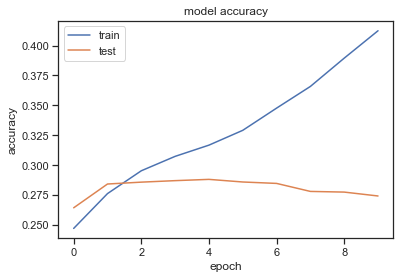

In [7]:
adam = optimizers.Adam()

#input_dim == 86 features
# creating our inital model
# after a lot of playing with the network topology, I landed on using 
# 7 hidden layers with between 1000 and 20 neurons. Using relu for activation
def create_model(optimizer):  
  model = Sequential() 
  model.add(Dense(1000, input_dim=n_features, activation='relu')) 
  model.add(Dense(750, activation='relu'))
  model.add(Dense(250, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(n_class, activation='softmax'))
  
  # compile model (using categorical crossentropy as we have 5 classes)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
  return model

model = create_model(adam)


# checkpointing
filepath="testmodel-weightsImprovment.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train_scaled, y_train_encoded, validation_split=0.2, epochs=10, batch_size=32, callbacks=callbacks_list)

# summarize history for accuracy 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

## 2.3 Baseline Model Comparison

I decided it would be a good idea to make use of sklearns dummy classifier model to test against my chosen network topology and see how it stacks up. The dummy classifier will provide us with an idea of baseline performance, for example, a success rate that you should expect to receive by simply guessing. I was quite happy with the results of this experiment as my model outperformed the dummy classifier by roughly 8% accuracy, meaning my model was working. Our dummy classifer had a test accuracy score of 19.5% and our model had a test accuracy score of 27.2%! Taking into consideration the size and size of parameters of our blob dataset, and the nature of generated isotropic gaussian blob data in general, this is quite a good result to achieve. I was happy with our initial network topology after this comparison, and decided it was time to move onto finer hyperparameter tuning using GridSearchCV.

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
import numpy as np 


dummy = DummyClassifier()
dummy.fit(X_train_scaled, y_train_encoded)

y_train_pred_dummy = dummy.predict(X_train_scaled)
y_train_pred_dummy = np.argmax(y_train_pred_dummy, axis=1)
y_train_pred_model = model.predict(X_train_scaled)
y_train_pred_model = np.argmax(y_train_pred_model, axis=1)

y_test_pred_dummy = dummy.predict(X_test_scaled)
y_test_pred_dummy = np.argmax(y_test_pred_dummy, axis=1)
y_test_pred_model = model.predict(X_test_scaled)
y_test_pred_model = np.argmax(y_test_pred_model, axis=1)

print('Train Performance')
print('Dummy -> Acc:', accuracy_score(y_train, y_train_pred_dummy) )
print('Model -> Acc:', accuracy_score(y_train, y_train_pred_model) )

print('Test Performance')
print('Dummy -> Acc:', accuracy_score(y_test, y_test_pred_dummy) )
print('Model -> Acc:', accuracy_score(y_test, y_test_pred_model) )

print('')
print('Classification Report')
print('Dummy ->')
print(classification_report(y_test, y_test_pred_dummy))
print('Model ->')
print(classification_report(y_test, y_test_pred_model))

#here we see our model has a near 50% increase 
#in test accuracy performance over our dummy classifier

Train Performance
Dummy -> Acc: 0.198725
Model -> Acc: 0.432175
Test Performance
Dummy -> Acc: 0.198
Model -> Acc: 0.2764

Classification Report
Dummy ->
              precision    recall  f1-score   support

           0       0.20      0.53      0.29      4007
           1       0.20      0.16      0.18      3968
           2       0.19      0.12      0.15      3957
           3       0.20      0.10      0.14      4027
           4       0.19      0.08      0.11      4041

   micro avg       0.20      0.20      0.20     20000
   macro avg       0.20      0.20      0.17     20000
weighted avg       0.20      0.20      0.17     20000

Model ->
              precision    recall  f1-score   support

           0       0.27      0.32      0.29      4007
           1       0.27      0.32      0.30      3968
           2       0.29      0.25      0.27      3957
           3       0.26      0.26      0.26      4027
           4       0.30      0.23      0.26      4041

   micro avg       0.2

## 3.1 Hyperparameter investigation

### 3.1.1 Grid Search
From looking at our previously plotted graph using our initial model, we can tell the model is becoming overfitted, we want to try our best to reduce this if we can. This led me to thinking about adding dropout layers after our dense layers to try combat this issue. I also thought that we could maybe try out the three different optimizers that I found were outputting the best results for me. I also wanted to try a few different learning rates to see if we could get our optimizers to train our model more accurately with dropout in the equation. So I created a parameter grid for our grid search, made up of my three choices of optimizer, a few logarithmic learning rates and some drop out values (including a drop out rate of 0 just in case drop out layers proved to be of no benefit to model accuracy). We ran the grid search locally utilizing n_jobs parameter and setting it to -1 to run the grid search using all 12 threads of my CPU’s 6 cores. We also made sure to set a safe value for pre_dispatch parameter (I went with 8 in this case) to make sure we avoided running into a nasty memory leak as I found this was a problem initially, unfortunately resulting in a couple of failed grid searches. Thankfully (after a few hours) our grid search completed, giving us a best accuracy of 29.5% using the following parameters
*	0.0 dropout rate
*	0.0001 learning rate
*	Adamax optimizer

To my surprise, our dropout layers didn’t help combat overfitting at all, and gave us poorer accuracy in general.


In [7]:
#################################################
pd.options.display.max_rows = 10000

# Function to create model, required for KerasClassifier
def create_model(optimizer, learning_rate, dropout_rate):
  model = Sequential() 
  model.add(Dense(1000, input_dim=n_features, activation='relu')) 
  model.add(Dropout(dropout_rate))
  model.add(Dense(750, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(250, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(20, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(n_class, activation='softmax'))
    
  # compile model (using categorical crossentropy as we have 5 classes)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr=learning_rate), metrics=['accuracy'])
  
  return model

modelGrid2 = KerasClassifier(build_fn=create_model, epochs=6, batch_size=200, verbose=1)

# define the grid search parameters
optimizer = [optimizers.Adam, optimizers.Adamax, optimizers.Nadam] 
learning_rate = [0.2, 0.1, 0.01, 0.001, 0.0001] 
dropout_rate = [0.0, 0.3, 0.55] # added value 0.55 as this is the computing student dropout rate in ireland :)
param_grid = dict(optimizer=optimizer,
                 learning_rate=learning_rate,
                 dropout_rate=dropout_rate)

# checkpointing (DOESN'T WORK FOR GRIDSEARCH)
# filepath="weights-improvement-SECOND-GRIDSEARCH.hdf5"
# checkpoint_grid = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list_grid = [checkpoint_grid]


grid = GridSearchCV(estimator=modelGrid2, param_grid=param_grid, n_jobs=-1, pre_dispatch=8) #n_jobs=-1 doesn't work colab
grid_result = grid.fit(X_train_scaled, y_train_encoded, validation_split=0.2)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 53599 samples, validate on 26401 samples
Epoch 1/6
53599/53599 [==============================] - 6s 115us/step - loss: 1.6065 - acc: 0.2065 - val_loss: 1.6010 - val_acc: 0.2165
Epoch 2/6
53599/53599 [==============================] - 5s 100us/step - loss: 1.5924 - acc: 0.2408 - val_loss: 1.5922 - val_acc: 0.2611
Epoch 3/6
53599/53599 [==============================] - 5s 102us/step - loss: 1.5779 - acc: 0.2791 - val_loss: 1.5833 - val_acc: 0.2736
Epoch 4/6
53599/53599 [==============================] - 5s 100us/step - loss: 1.5613 - acc: 0.2974 - val_loss: 1.5741 - val_acc: 0.2789
Epoch 5/6
53599/53599 [==============================] - 5s 102us/step - loss: 1.5457 - acc: 0.3103 - val_loss: 1.5699 - val_acc: 0.2838
Epoch 6/6
53599/53599 [==============================] - 5s 100us/step - loss: 1.5308 - acc: 0.3214 - val_loss: 1.5672 - val_acc: 0.2862
Best: 0.295812 using {'dropout_rate': 0.0, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.Adamax'>}
0.200775 (0.

### 3.1.2 Second Grid Search
After reaching our optimal parameters from the last grid search, it appeared that using dropout layers had proved to not be of any benefit to our model training. Due to this we cut out the dropout layers and decided to do a grid search for optimal batch size and epochs using our best optimizer, Adamax. 

In [10]:
# checkpointing
#filepath="/content/gdrive/My Drive/weights-improvement-GRIDSEARCH-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint_grid = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list_grid = [checkpoint_grid]

def create_test_model(optimizer):  
  model = Sequential() 
  model.add(Dense(1000, input_dim=n_features, activation='relu')) 
  model.add(Dense(750, activation='relu'))
  model.add(Dense(250, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(n_class, activation='softmax'))
  
  # compile model (using categorical crossentropy as we have 5 classes)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr=0.0001), metrics=['accuracy'])
  
  return model


optimizer = [optimizers.Adamax]
batch_size = [10, 20, 50, 100, 200]
epochs = [2, 6, 10]
param_grid = dict(epochs=epochs, 
                  batch_size=batch_size, 
                  optimizer=optimizer)



modelGrid = KerasClassifier(build_fn=create_test_model , verbose=1)

test_grid = GridSearchCV(estimator=modelGrid, param_grid=param_grid, n_jobs=-1, pre_dispatch=9) #n_jobs=-1 doesn't work colab
test_grid_result = test_grid.fit(X_train_scaled, y_train_encoded, validation_split=0.2)

C:\Users\dnlma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 64000 samples, validate on 16000 samples
Epoch 1/2
64000/64000 [==============================] - 15s 233us/step - loss: 1.5804 - acc: 0.2685 - val_loss: 1.5610 - val_acc: 0.2971
Epoch 2/2
64000/64000 [==============================] - 14s 219us/step - loss: 1.5466 - acc: 0.3087 - val_loss: 1.5524 - val_acc: 0.3026


### Second Grid Search results
Our second grid search gave us a best accuracy of 30%! Our model is now 11% more efficient than the dummy model. This might not sound like a lot, but every improvement no matter how small, is still an improvement in our model and positive overall. The best parameters for this grid search was to run just 2 epochs with a batch size of 50 using optimizer Adamax

In [11]:
print(test_grid_result.best_score_, ' ', test_grid_result.best_params_)


0.30058750098096204   {'batch_size': 50, 'epochs': 2, 'optimizer': 'adamax'}


## 4.1 Final Model Presentation
I was happy to use these best parameters from our two grid searches in our final model. We created our final model, and made sure to save our model as a JSON file, along with saving our best weights improvement to a hierarchical data format file for use in our prediction later. It’s now time to implement early stopping in our final model in order to get the best accuracy. The model stopped early after 4 epochs, selecting the best accuracy as epoch 3 with a test accuracy score of 30.7%

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 64000 samples, validate on 16000 samples
Epoch 1/5
64000/64000 [==============================] - 14s 218us/step - loss: 1.5947 - acc: 0.2413 - val_loss: 1.5736 - val_acc: 0.2741

Epoch 00001: val_acc improved from -inf to 0.27412, saving model to final-model-weightsImprovment.hdf5
Epoch 2/5
64000/64000 [==============================] - 14s 213us/step - loss: 1.5577 - acc: 0.2942 - val_loss: 1.5606 - val_acc: 0.2877

Epoch 00002: val_acc improved from 0.27412 to 0.28769, saving model to final-model-weightsImprovment.hdf5
Epoch 3/5
64000/64000 [==============================] - 16s 243us/step - loss: 1.5389 - acc: 0.3159 - val_loss: 1.5556 - val_acc: 0.2988

Epoch 00003: val_acc improved from 0.28769 to 0.29881, saving model to final-model-weightsImprovment.hdf5
Epoch 4/5
64000/64000 [==============================] - 15s 242us/step - loss: 1.5234 - acc: 0.33

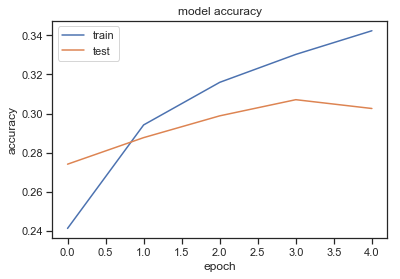

In [17]:
def create_final_model(optimizer, learning_rate):  
  model = Sequential() 
  model.add(Dense(1000, input_dim=n_features, activation='relu')) 
  model.add(Dense(750, activation='relu'))
  model.add(Dense(250, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(n_class, activation='softmax'))
  
  # compile model (using categorical crossentropy as we have 5 classes)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr=learning_rate), metrics=['accuracy'])
  
  # serialize model to JSON
  model_json = model.to_json()
  with open("modelStructure.json", "w") as json_file: 
    json_file.write(model_json)
    
  return model

optimizer = optimizers.Adamax
learning_rate = 0.0001
epochs = 2
batch_size = 50
final_model = create_final_model(optimizers.Adamax, learning_rate)

# early stopping 
es = EarlyStopping(monitor='val_acc')

# checkpointing
filepath="final-model-weightsImprovment.hdf5"
checkpoint_final = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_final = [checkpoint_final, es]

# callbacks=callbacks_list
final_model_history = final_model.fit(X_train_scaled, y_train_encoded, validation_split=0.2, epochs=5, batch_size=batch_size, callbacks=callbacks_list_final) 

# summarize history for accuracy 
plt.plot(final_model_history.history['acc']) 
plt.plot(final_model_history.history['val_acc']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()


## 4.2 Performance Evaluation and Summary
It’s time to predict our model using our final model we saved to a json file and our best weights from our early stopping in the final run of our model. We run the model on our unseen test data that we put aside during data preprocessing and see an accuracy of 30.7% along with a loss of 1.548. We have successfully trained our model to perform upwards 50% more efficiently than guessing or using a dummy model. 


In [18]:
#load the saved model in
json_file = open('modelStructure.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
file = "final-model-weightsImprovment.hdf5" 
loaded_model.load_weights(file)

# compile model (using categorical crossentropy as we have 5 classes)
loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr=learning_rate), metrics=['accuracy'])
  
# evaluate the model 
scores = loaded_model.evaluate(X_test_scaled, y_test_encoded, verbose=1) 

print(loaded_model.metrics_names[1], scores[1]*100)
print(loaded_model.metrics_names[0], scores[0])

20000/20000 [==============================] - 1s 56us/step
acc 30.72
loss 1.5482922130584718


## 4.3 Conclusion:
Our model can predict which of the 5 clusters a value belongs to, with 30% certainty. I learned a lot of valuable information from this project. I had a lot of trouble with many parts of the project including using cloud hosted kernals, file output, grid searches and much more. I now know how to do all of these things and have a better understanding of how to train a deep neural network using Keras. A lot of what i've learned will be useful knowledge for future Neural Net projects.
